In [167]:
import pandas as pd
import numpy as np
import datetime, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import random

In [2]:
def get_unix(latency):
    millisecond = datetime.datetime.now() - datetime.timedelta(seconds=latency)
    unixtimestamp = int(millisecond.timestamp() * 1000)
    return unixtimestamp

In [3]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

In [4]:
df = pd.read_csv("conceptdrift/Data/data_drift_20.csv",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'latency': pd.Series(dtype='float'),
                   'drift': pd.Series(dtype='int')})

In [5]:
def isAllowed(driftTime, detectTime, threshold):
    
    tsDrift = datetime.datetime.fromtimestamp(int(driftTime)/1000)  
    tsDetect = datetime.datetime.fromtimestamp(int(detectTime)/1000)  
    diff = tsDetect - tsDrift
    diff = diff.total_seconds()
    if diff > 0 and diff <= threshold:
        return True
    return False
    

In [6]:
def evaluate(threshold, df_p):
    detectedTS = df_p["ingestion"].tolist()
    driftsTS = df.query("drift == 1")["ingestion"].tolist()
    counterResult = 0
    result= dict()
    result["name"] =  df_p["algorithm"].unique()[0]
    result["predictedDrift"] = len(detectedTS)
    
    for i in driftsTS:

        for j in detectedTS:
            accept = isAllowed(i, j, threshold)
            if accept:
                counterResult +=  1
                break
    acc = (counterResult/len(detectedTS))*100
    
    result["acceptedDrift"] =counterResult
    result["acc"] = acc
    return result

In [9]:
files = ["result_sudden_ADWIN.csv","result_sudden_GMADM.csv", "result_sudden_CUSUM.csv", "result_sudden_PageHinkley.csv"]

In [115]:
thresholds = [0.75, 1, 1.25, 1.5, 1.75]
df_result = pd.DataFrame({'algorithm': pd.Series(dtype='str'),'threshold': pd.Series(dtype='int'),
                   'accuracy': pd.Series(dtype='float'),'predictedDrift': pd.Series(dtype='int'),'accepted': pd.Series(dtype='int'), })


for f in files:
    df_processed = pd.read_csv(f"conceptdrift/Data/result/{f}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
    
    
    for t in thresholds:
        result = evaluate(t, df_processed)
        df_result = df_result.append({"algorithm":result["name"] ,"threshold": t, "accuracy": result["acc"],
                                      "accepted":result["acceptedDrift"], "predictedDrift": result["predictedDrift"]},ignore_index=True) 

In [117]:
df_result.to_json()

'{"algorithm":{"0":"ADWIN","1":"ADWIN","2":"ADWIN","3":"ADWIN","4":"ADWIN","5":"GMADM","6":"GMADM","7":"GMADM","8":"GMADM","9":"GMADM","10":"CUSUM","11":"CUSUM","12":"CUSUM","13":"CUSUM","14":"CUSUM","15":"PageHinkley","16":"PageHinkley","17":"PageHinkley","18":"PageHinkley","19":"PageHinkley"},"threshold":{"0":0.75,"1":1.0,"2":1.25,"3":1.5,"4":1.75,"5":0.75,"6":1.0,"7":1.25,"8":1.5,"9":1.75,"10":0.75,"11":1.0,"12":1.25,"13":1.5,"14":1.75,"15":0.75,"16":1.0,"17":1.25,"18":1.5,"19":1.75},"accuracy":{"0":47.619047619,"1":47.619047619,"2":47.619047619,"3":47.619047619,"4":47.619047619,"5":25.0,"6":75.0,"7":75.0,"8":75.0,"9":75.0,"10":72.7272727273,"11":81.8181818182,"12":90.9090909091,"13":90.9090909091,"14":90.9090909091,"15":25.0,"16":25.0,"17":25.0,"18":25.0,"19":25.0},"predictedDrift":{"0":42,"1":42,"2":42,"3":42,"4":42,"5":4,"6":4,"7":4,"8":4,"9":4,"10":11,"11":11,"12":11,"13":11,"14":11,"15":4,"16":4,"17":4,"18":4,"19":4},"accepted":{"0":20,"1":20,"2":20,"3":20,"4":20,"5":1,"6":3,"7

In [116]:
df_result

,algorithm,threshold,accuracy,predictedDrift,accepted
0,ADWIN,0.75,47.619048,42,20
1,ADWIN,1.00,47.619048,42,20
2,ADWIN,1.25,47.619048,42,20
3,ADWIN,1.50,47.619048,42,20
4,ADWIN,1.75,47.619048,42,20
5,GMADM,0.75,25.000000,4,1
6,GMADM,1.00,75.000000,4,3
7,GMADM,1.25,75.000000,4,3
8,GMADM,1.50,75.000000,4,3
9,GMADM,1.75,75.000000,4,3


In [11]:
files= ["result_sudden_ADWIN.csv"]

In [24]:
def plot_drifts(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"conceptdrift/Data/result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.plot(df["latency"], label='Stream')

        driftsExtra = df_processed["indexNumber"].tolist()
        """
        drifts= list(df.query("drift == 1").index)
        if len(drifts) > 0:
            for i in drifts:
                ax1.axvline(i, color='red')
        """
        for i in driftsExtra:
            ax1.axvline(i, color='orange')
    plt.xlim([800, 1200])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

In [ ]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

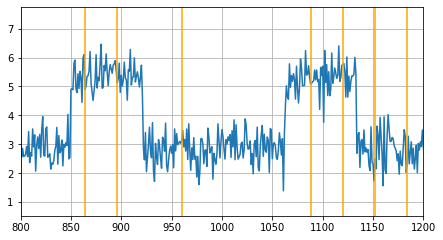

In [25]:
plot_drifts(df,files, "drift_result_plots.png")

In [92]:
df_processed

NameError: name 'df_processed' is not defined

In [172]:
def plot_drifts_ex(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"conceptdrift/Data/result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.set_xlabel('ingestion unix timestamp')
        ax1.plot(df["ingestion"],df["latency"], label='Stream')

        driftsExtra = df_processed["ingestion"].tolist()
        
        drifts= df.query("drift == 1")
        if drifts.shape[0] > 0:
            for index, row in drifts.iterrows():
                ax1.axvline(int(row["ingestion"]), color='red')
       
        for i in driftsExtra:
            ax1.axvline(int(i), color='orange')
        
    plt.xlim([1658333948701, 1658333951107])
    
    #plt.ylim([0, 7])
    red_patch = mpatches.Patch(color='red', label='actual drift')
    orange_patch = mpatches.Patch(color='orange', label='predicted drift')
    plt.legend(handles=[red_patch,orange_patch])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

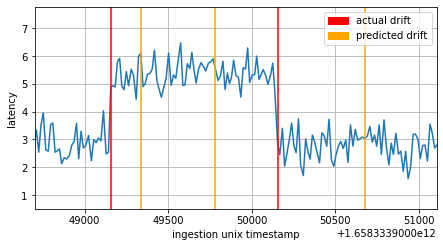

In [173]:
plot_drifts_ex(df,files, "drift_result_adwin_detail.png")